## 1. Data Collection and S3 Storage

Our `spy_daily.csv` dataset (daily OHLCV for SPY) has been manually reviewed, cleaned, and uploaded to S3 at:
`s3://aai540-stock-datalake/raw/spy_daily.csv`


## 2. Athena Table Setup

Set up the Athena table to enable SQL-based querying and cataloging of the raw S3 data. (this is run in Athena Console)



In [ ]:
-- DDL for Athena table (run in Athena Console)
DROP TABLE IF EXISTS default.spy_daily;

CREATE EXTERNAL TABLE IF NOT EXISTS default.spy_daily (
    date string,
    open double,
    high double,
    low double,
    close double,
    volume bigint
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "skip.header.line.count" = "1"
)
LOCATION 's3://aai540-stock-datalake/raw/'
TBLPROPERTIES ('has_encrypted_data'='false');


## Exploratory Data Analysis and Feature Engineering

Load the cleaned daily SPY and QQQ datasets, do a quick review, then expand feature engineering to cover the technical signals and anomaly flags outlined in the project plan.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load SPY and QQQ data
df = pd.read_csv('data/spy_daily.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

qqq = pd.read_csv('data/qqq_daily.csv')
qqq['date'] = pd.to_datetime(qqq['date'])
qqq = qqq[['date', 'close']].rename(columns={'close': 'qqq_close'})

# Join for relative strength calculation
df = df.merge(qqq, on='date', how='left')

# Quick look at missing values and summary stats
print(df.isnull().sum())
print(df.describe())


date         0
open         0
high         0
low          0
close        0
volume       0
qqq_close    0
dtype: int64
                                date         open         high          low  \
count                           5033  5033.000000  5033.000000  5033.000000   
mean   2015-04-13 14:36:38.768130304   241.646676   243.015926   240.151912   
min              2005-04-15 00:00:00    67.950000    70.000000    67.100000   
25%              2010-04-15 00:00:00   132.730000   133.400000   131.780000   
50%              2015-04-15 00:00:00   202.400000   203.370000   201.350000   
75%              2020-04-14 00:00:00   314.430000   315.640000   312.760000   
max              2025-04-15 00:00:00   611.540000   613.230000   609.560000   
std                              NaN   132.736560   133.409722   131.984220   

             close        volume    qqq_close  
count  5033.000000  5.033000e+03  5033.000000  
mean    241.677071  1.258952e+08   155.702685  
min      68.110000  1.5270

### Price and Volume Plots

Visualize historical trends for a sanity check.


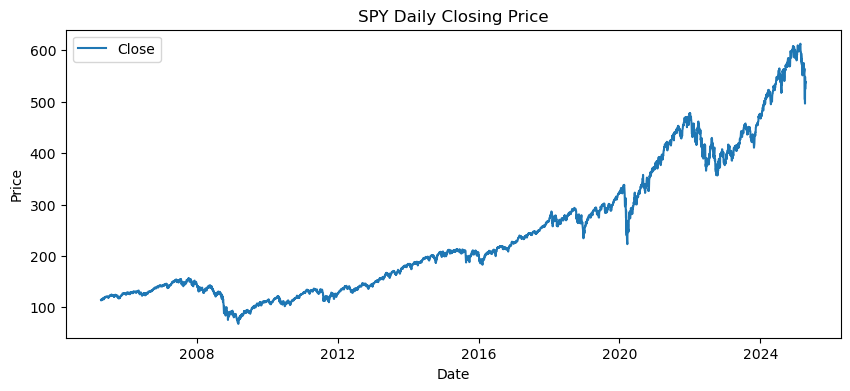

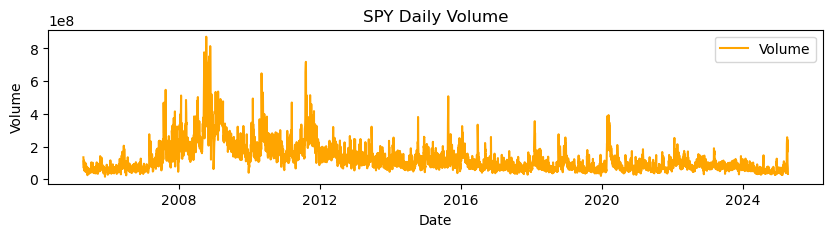

In [21]:
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPY Daily Closing Price')
plt.legend()
plt.show()

plt.figure(figsize=(10,2))
plt.plot(df['date'], df['volume'], label='Volume', color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('SPY Daily Volume')
plt.legend()
plt.show()


### Core Feature Engineering

Add returns, moving averages, volatility, RSI, MACD, Bollinger Bands, ATR, VWAP, regime tags, relative strength, and anomaly flags.


In [22]:
# Returns and rolling averages
df['return'] = df['close'].pct_change()
df['sma_5'] = df['close'].rolling(5).mean()
df['sma_20'] = df['close'].rolling(20).mean()
df['sma_50'] = df['close'].rolling(50).mean()
df['volatility_20'] = df['return'].rolling(20).std()

# RSI (14-day)
def calc_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rsi = 100 - (100/(1 + ma_up/ma_down))
    return rsi
df['rsi_14'] = calc_rsi(df['close'])

# MACD
df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20d)
df['bb_mid'] = df['close'].rolling(20).mean()
df['bb_std'] = df['close'].rolling(20).std()
df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']

# ATR (14d)
high_low = df['high'] - df['low']
high_close = (df['high'] - df['close'].shift()).abs()
low_close = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['atr_14'] = tr.rolling(14).mean()

# VWAP (Volume Weighted Average Price for each day)
df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

# Relative Strength vs QQQ
df['rel_strength_qqq'] = df['close'] / df['qqq_close']

# Regime tagging: simple bull/bear/volatile based on price vs. 50d SMA and rolling vol
conditions = [
    (df['close'] > df['sma_50']) & (df['volatility_20'] < 0.015),
    (df['close'] < df['sma_50']) & (df['volatility_20'] > 0.025),
]
choices = ['bull', 'bear']
df['regime'] = np.select(conditions, choices, default='volatile')

# Volume spike (3x 20d rolling median)
df['vol_spike'] = (df['volume'] > 3 * df['volume'].rolling(20).median()).astype(int)
# Extreme return (|return| > 3x 20d rolling std)
df['extreme_return'] = (df['return'].abs() > 3 * df['return'].rolling(20).std()).astype(int)


### Clean Up and Save Engineered Features

Drop early rows with NA, check final set, and save to file.


In [23]:
final_features = [
    'date', 'open', 'high', 'low', 'close', 'volume', 'return',
    'sma_5', 'sma_20', 'sma_50',
    'rsi_14', 'macd', 'macd_signal',
    'bb_mid', 'bb_upper', 'bb_lower',
    'atr_14', 'vwap', 'rel_strength_qqq', 'regime', 'vol_spike', 'extreme_return'
]
df_feat = df[final_features].dropna().reset_index(drop=True)
df_feat.head()

# Save to disk (for upload to S3/Feature Store if needed)
df_feat.to_csv('data/spy_daily_features.csv', index=False)


### Split Data for Modeling

Train (40%), validation (10%), test (10%), holdout production (40%) split.


In [24]:
n = len(df_feat)
train_end = int(n * 0.4)
val_end = int(n * 0.5)
test_end = int(n * 0.6)

train = df_feat.iloc[:train_end].copy()
val = df_feat.iloc[train_end:val_end].copy()
test = df_feat.iloc[val_end:test_end].copy()
prod = df_feat.iloc[test_end:].copy()

print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")
print(f"Production (holdout) shape: {prod.shape}")


Train shape: (1993, 22)
Validation shape: (499, 22)
Test shape: (498, 22)
Production (holdout) shape: (1994, 22)


### Optionally save splits for future reference or downstream modeling.


In [25]:
train.to_csv('data/spy_daily_train.csv', index=False)
val.to_csv('data/spy_daily_val.csv', index=False)
test.to_csv('data/spy_daily_test.csv', index=False)
prod.to_csv('data/spy_daily_production.csv', index=False)

# Example S3 upload if needed:
# s3.upload_file('data/spy_daily_train.csv', 'aai540-stock-datalake', 'feature_store/spy_daily_train.csv')


## Summary

Expanded feature engineering to align with the project plan, adding MACD, Bollinger Bands, ATR, VWAP, regime tagging, relative strength, and anomaly flags. Data is now split and ready for modeling and anomaly detection.
